# Introduction

We have been given a dataset containing the data of images of wells, the wells are ordered in columns and rows into the well plate. The wells contain bacteria that react with gold and change their color accordingly, we want to predict the gold concentration of wells. The dataset features are many and relating the well positioning, the camera settings and the "image channel" settings. The labels are `class_target`, that is the "class of concentration", and the `value_target`, that is the concentration of gol itself.

The unit of measure of concentration in `class_target` used is "CFU/ml". CFU stands for Colony Forming Units, which is a measure used in microbiology to estimate the number of viable bacteria or fungal cells in a sample. It's not a direct measurement of the total quantity of bacteria, but rather a measure of the number of cells capable of dividing and forming colonies.In simple words, it is the number of "units of bacteria" capable of forming colonies, therefore "CFU/ml" it's "units of bacteria capable of forming colonies in a milliliter of liquid".

In [1]:
import pandas as pd

df = pd.read_pickle('df.pkl')

We define some utils

In [2]:
from utils import print_full_classification_report, print_full_regression_report, create_training_history_plot, get_features, RegressionClassifier

# Dataset analysis

We start analyzing features

In [3]:
LABEL_COLUMNS = ['class_target', 'value_target']
CLASSES = sorted(df['class_target'].unique())
CLASSES_SHORT = [class_.split(' CFU:mL')[0] for class_ in CLASSES]
FEATURES_COLUMNS = [col for col in df.columns if col not in LABEL_COLUMNS]

# Print numeric features and one example value using pd.api.types.is_numeric_dtype
NUMERICAL_FEATURES = [col for col in FEATURES_COLUMNS if pd.api.types.is_numeric_dtype(df[col])]
CATEGORICAL_FEATURES = [col for col in FEATURES_COLUMNS if col not in NUMERICAL_FEATURES]

print('Number of numeric features:', len(NUMERICAL_FEATURES))
print('Number of categorical features:', len(CATEGORICAL_FEATURES))
print(f'Total number of features: {len(NUMERICAL_FEATURES) + len(CATEGORICAL_FEATURES)}')
print(f'Percentage of categorical features: {len(CATEGORICAL_FEATURES) / len(df.columns) * 100}%')
print(f'Percentage of numeric features: {len(NUMERICAL_FEATURES) / len(df.columns) * 100}%')

print('Numeric features:')
for col in NUMERICAL_FEATURES:
    print(f'\t{col}: {df[col].iloc[0]}')

print('Categorical features:')
for col in CATEGORICAL_FEATURES:
    print(f'\t{col}: {df[col].iloc[0]}')

Number of numeric features: 167
Number of categorical features: 11
Total number of features: 178
Percentage of categorical features: 6.111111111111111%
Percentage of numeric features: 92.77777777777779%
Numeric features:
	wp_image_prop: 0.0
	mock: False
	FocalLengthIn35mmFilm: 0.0
	ISOSpeedRatings: 226.0
	Orientation: 1.0
	Flash: 16.0
	MeteringMode: 2.0
	full_gray_mean: 76.37894375857339
	full_gray_stddev: 42.19194116854811
	full_gray_mean_trm30: 89.51971710244321
	full_gray_skewness: -0.985075922379453
	full_gray_entropy: 4.823225765539228
	full_gray_entropy2: 3.3432053405876
	full_gray_entropy_glcm: 7.1244046874085125
	full_gray_mean_PIL: 76.37894375857339
	full_blue_mean: 66.73251028806584
	full_blue_stddev: 38.11588827465449
	full_blue_mean_trm30: 75.86755250750107
	full_blue_skewness: -0.7398326957511079
	full_blue_entropy: 4.923509474933315
	full_blue_entropy2: 3.4127167110102032
	full_blue_entropy_glcm: 7.267878672884646
	full_blue_mean_PIL: 66.73251028806584
	full_green_mean: 6

We decide to keep categorical features, even tho they are in a smaller amout, because they might contain precious information. We will use Feature importance that is a method that works both for categorical and numerical features.

We drop features with no variance, because they are useless

In [4]:
# Drop feature that are constant
CONSTANT_FEATURES = [col for col in FEATURES_COLUMNS if df[col].nunique() == 1]
df_dropped = df.drop(columns=CONSTANT_FEATURES)

# Feature selection

We perform feature selection using feature importance with random forest. We need to perform one hot encoding in order to do that.

In [7]:
# Perform one-hot encoding
FEATURES_COLUMNS = get_features(df_dropped)
NUMERICAL_FEATURES = [col for col in FEATURES_COLUMNS if pd.api.types.is_numeric_dtype(df_dropped[col])]
CATEGORICAL_FEATURES = [col for col in FEATURES_COLUMNS if col not in NUMERICAL_FEATURES]

print(f"Number of columns before one hot encoding: {len(df_dropped.columns)}")
df_dropped_onehot = pd.get_dummies(df_dropped, columns=CATEGORICAL_FEATURES)
print(f"Number of columns after one hot encoding: {len(df_dropped_onehot.columns)}")

Number of columns before one hot encoding: 169
Number of columns after one hot encoding: 1035


In [9]:
# Do feature selection using feature importance with Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

le = LabelEncoder()
FEATURES_COLUMNS = get_features(df_dropped_onehot)
X = df_dropped_onehot[FEATURES_COLUMNS]
y = le.fit_transform(df_dropped_onehot["class_target"])

# Train a random forest classifier
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X, y)

# Get feature importances
feature_importances = rf.feature_importances_

We perform feature importance with Random Forest and, b manually looking at the values of feature importance, we notice that starting from the 36 the importance value decreses drastically, therefore we decided to keep the first 35 features, sorted by importance.

feature_columns_with_importance[:NUMBER_OF_FEATURES_TO_PLOT] = [('full_a_stddev', 0.03756122724110633), ('a_stddev', 0.027928612214916614), ('ISOSpeedRatings', 0.02659899980863722), ('b_mean_PIL', 0.022383277999904007), ('a_mean_PIL', 0.02164280294589329), ('a_entropy', 0.01994843175760778), ('full_b_mean_PIL', 0.019799841798844905), ('full_S_stddev', 0.019373783818473406), ('a_mean', 0.018871162977466893), ('H_stddev', 0.01789202827892888), ('full_a_mean_trm30', 0.01781785620908613), ('full_b_stddev', 0.017322067774991838), ('full_a_mean_PIL', 0.017273531380943244), ('full_b_mean_trm30', 0.01695738494930129), ('full_b_mean', 0.01695288362978248)]
sorted_feature_columns = ['full_a_stddev', 'a_stddev', 'ISOSpeedRatings', 'b_mean_PIL', 'a_mean_PIL', 'a_entropy', 'full_b_mean_PIL', 'full_S_stddev', 'a_mean', 'H_stddev', 'full_a_mean_trm30', 'full_b_stddev', 'full_a_mean_PIL', 'full_b_mean_trm30', 'full_b_mean']
sorted_feature_importances = [0.03756122724110633, 0.027928612214916614, 0.026

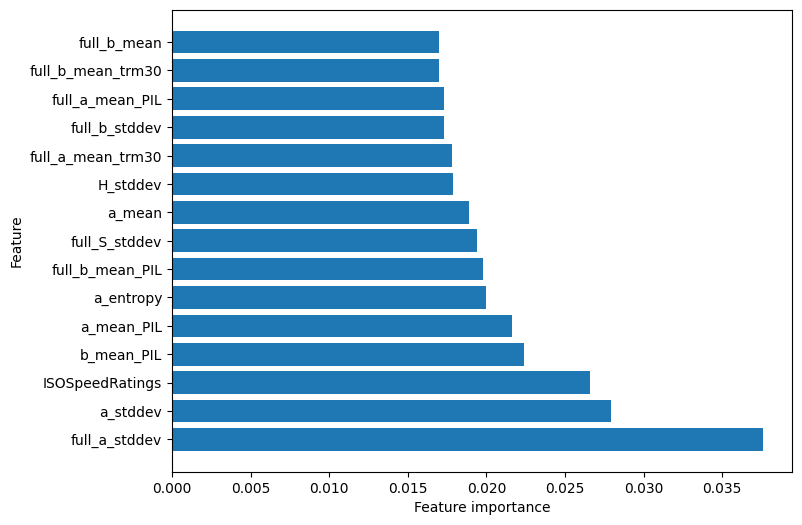

1. full_a_stddev: 0.03756122724110633
2. a_stddev: 0.027928612214916614
3. ISOSpeedRatings: 0.02659899980863722
4. b_mean_PIL: 0.022383277999904007
5. a_mean_PIL: 0.02164280294589329
6. a_entropy: 0.01994843175760778
7. full_b_mean_PIL: 0.019799841798844905
8. full_S_stddev: 0.019373783818473406
9. a_mean: 0.018871162977466893
10. H_stddev: 0.01789202827892888
11. full_a_mean_trm30: 0.01781785620908613
12. full_b_stddev: 0.017322067774991838
13. full_a_mean_PIL: 0.017273531380943244
14. full_b_mean_trm30: 0.01695738494930129
15. full_b_mean: 0.01695288362978248
16. ShutterSpeedValue_5.614: 0.016663348989870364
17. ExposureTime_0.020003: 0.016095233589592424
18. full_a_entropy2: 0.015681888873406033
19. S_stddev: 0.015546903198722787
20. b_mean: 0.015246905882261314
21. full_S_mean: 0.015017331467168134
22. a_entropy2: 0.014778539806744732
23. S_entropy2: 0.014762819682866466
24. full_a_mean: 0.014284572763561114
25. S_mean_PIL: 0.01405821938665438
26. a_mean_trm30: 0.013867618170138388

In [13]:
# Sort features by importance using sorted
FEATURES_COLUMNS = get_features(df_dropped_onehot)
NUMBER_OF_FEATURES_TO_PLOT = 15
feature_columns_with_importance = sorted(zip(FEATURES_COLUMNS, feature_importances), key=lambda x: x[1], reverse=True)

print(f"{feature_columns_with_importance[:NUMBER_OF_FEATURES_TO_PLOT] = }")

sorted_feature_columns = [feature_column_with_importance[0] for feature_column_with_importance in feature_columns_with_importance[:NUMBER_OF_FEATURES_TO_PLOT]]
sorted_feature_importances = [feature_column_with_importance[1] for feature_column_with_importance in feature_columns_with_importance[:NUMBER_OF_FEATURES_TO_PLOT]]

print(f"{sorted_feature_columns = }")
print(f"{sorted_feature_importances = }")

# Create a plot for the feature importances
plt.figure(figsize=(8, 6))
plt.barh(sorted_feature_columns, sorted_feature_importances)
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

# Print sorted features
for i, (feature, importance) in enumerate(feature_columns_with_importance):
    print(f"{i + 1}. {feature}: {importance}")

# Keep the first 35 features
NUMBER_OF_FEATURES_TO_KEEP = 35
FEATURES_COLUMNS = sorted_feature_columns[:NUMBER_OF_FEATURES_TO_KEEP]
df_feature_importance_sorted = df_dropped_onehot[FEATURES_COLUMNS + LABEL_COLUMNS]
df_feature_importance_sorted.to_pickle('df_feature_importance_sorted.pkl')

We save the X and y data

In [16]:
import pickle
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

df_feature_importance_sorted = pickle.load(open('df_feature_importance_sorted.pkl', 'rb'))
FEATURES_COLUMNS = [col for col in df_feature_importance_sorted.columns if col not in LABEL_COLUMNS]
scaler = MinMaxScaler()
le = LabelEncoder()

# MinMaxScaler is useful for many models we use here
X = scaler.fit_transform(df_feature_importance_sorted[FEATURES_COLUMNS])
# X = df_feature_importance_sorted[FEATURES_COLUMNS].to_numpy()
y = le.fit_transform(df_feature_importance_sorted["class_target"])

# Save to pickle file
pickle.dump(X, open('X_feature_importance_classification.pkl', 'wb'))
pickle.dump(y, open('y_feature_importance_classification.pkl', 'wb'))

# Dimensionality visualization

We won't perform densionality reduction. Let's visualize the date in 2 and 3 dimensions.

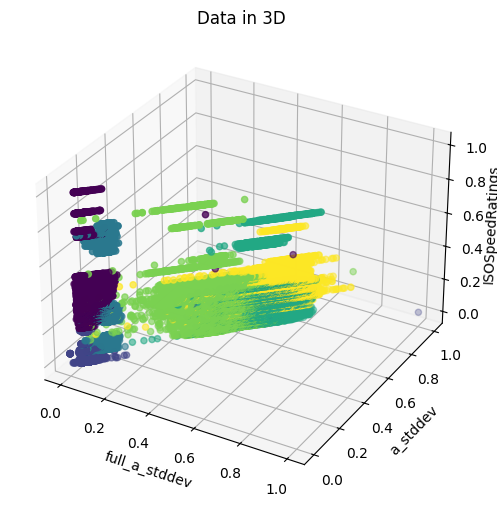

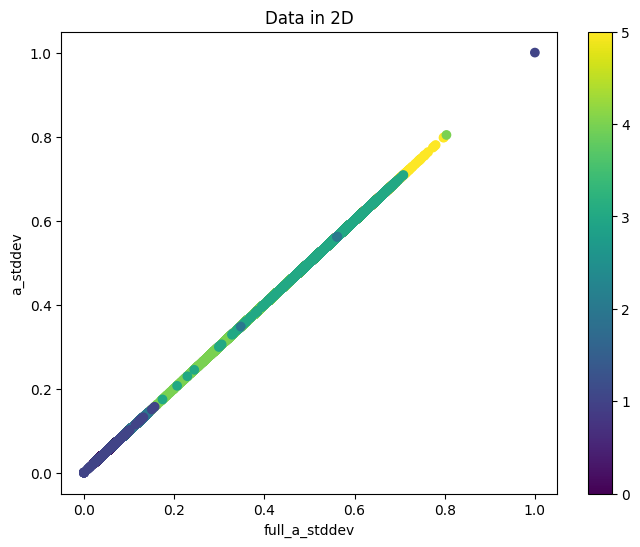

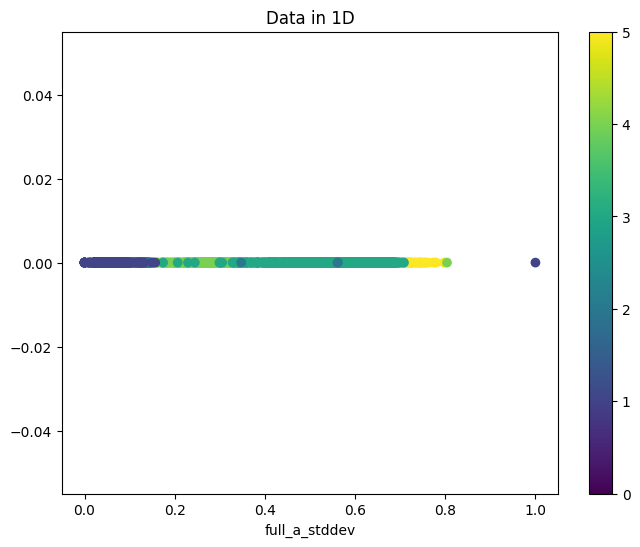

In [27]:
# Import X and y from a pickle files
import pickle

df_feature_importance_sorted = pickle.load(open('df_feature_importance_sorted.pkl', 'rb'))
X = pickle.load(open('X_feature_importance_classification.pkl', 'rb'))
y = pickle.load(open('y_feature_importance_classification.pkl', 'rb'))

# Plot the data in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis')
ax.set_xlabel(df_feature_importance_sorted.columns[0])
ax.set_ylabel(df_feature_importance_sorted.columns[1])
ax.set_zlabel(df_feature_importance_sorted.columns[2])
ax.set_title('Data in 3D')
ax.zaxis.labelpad=-1        # Improve visibility of the z-axis label
plt.show()


# Plot the data in the principal component space
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.xlabel(df_feature_importance_sorted.columns[0])
plt.ylabel(df_feature_importance_sorted.columns[1])
plt.title('Data in 2D')
plt.colorbar()

zeros = [0 for _ in range(len(X[:, 1]))]
# Plot the data in the principal component space
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], zeros, c=y, cmap='viridis')
plt.xlabel(df_feature_importance_sorted.columns[0])
plt.title('Data in 1D')
plt.colorbar()

# Training - Classification

Let's define the train and test set.

In [22]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

df_feature_importance_sorted = pickle.load(open('df_feature_importance_sorted.pkl', 'rb'))
FEATURES_COLUMNS = [col for col in df_feature_importance_sorted.columns if col not in LABEL_COLUMNS]

# Open pickle files from X_numeric.pkl and y_numeric.pkl
X = pickle.load(open('X_feature_importance_classification.pkl', 'rb'))
y = pickle.load(open('y_feature_importance_classification.pkl', 'rb'))

# Set the test size
test_size = 0.2

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42) # random_state set for reproducibility

# Print the shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Print unique values of y_train and y_test
print()
print(f"Unique values of y_train: {np.unique(y_train)}")

# Print example of train and test data
print()
print("Example of train data:")
print(f"X_train[0]: {X_train[0]}")
print(f"y_train[0]: {y_train[0]}")

print()
print("Example of test data:")
print(f"X_test[0]: {X_test[0]}")
print(f"y_test[0]: {y_test[0]}")

# Save to pickle files
pickle.dump(X_train, open('X_feature_importance_train_classification.pkl', 'wb'))
pickle.dump(X_test, open('X_feature_importance_test_classification.pkl', 'wb'))
pickle.dump(y_train, open('y_feature_importance_train_classification.pkl', 'wb'))
pickle.dump(y_test, open('y_feature_importance_test_classification.pkl', 'wb'))


X_train shape: (49612, 15)
X_test shape: (12404, 15)
y_train shape: (49612,)
y_test shape: (12404,)

Unique values of y_train: [0 1 2 3 4 5]

Example of train data:
X_train[0]: [0.03002198 0.03002198 0.51459854 0.48554863 0.05826815 0.25713777
 0.48554863 0.24053471 0.05826815 0.46582945 0.0627535  0.13494003
 0.05826815 0.30688604 0.48554863]
y_train[0]: 0

Example of test data:
X_test[0]: [0.04319353 0.04319353 0.01824818 0.40598983 0.10281676 0.36992976
 0.40598983 0.25713177 0.10281676 0.47902331 0.09581046 0.1724398
 0.10281676 0.21051685 0.40598983]
y_test[0]: 1


We import the training and test data

In [24]:
# Import the training and test data from pickle files
import pickle

X = pickle.load(open('X_feature_importance_classification.pkl', 'rb'))
X_train = pickle.load(open('X_feature_importance_train_classification.pkl', 'rb'))
X_test = pickle.load(open('X_feature_importance_test_classification.pkl', 'rb'))
y = pickle.load(open('y_feature_importance_classification.pkl', 'rb'))
y_train = pickle.load(open('y_feature_importance_train_classification.pkl', 'rb'))
y_test = pickle.load(open('y_feature_importance_test_classification.pkl', 'rb'))

CLASSIFICATION_PLOT_AXES = ["full_a_stddev", "a_stddev"]

We apply Naive Bayes, that has the model performance that we want to beat.

Accuracy: 0.9222831344727507
Scatter plot of the test data:


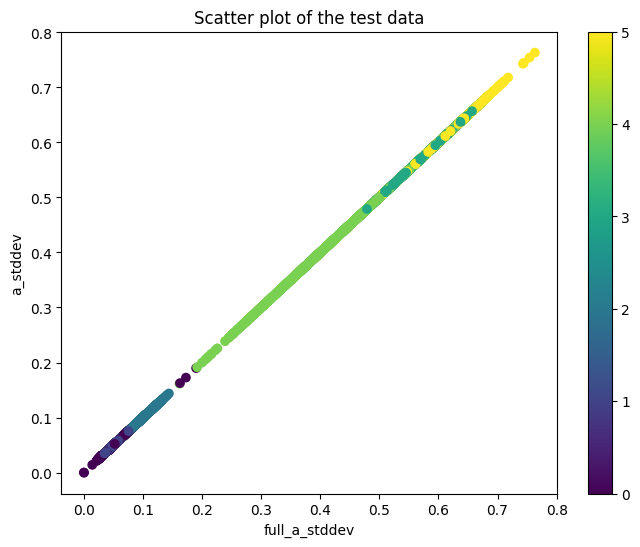

Confusion matrix:


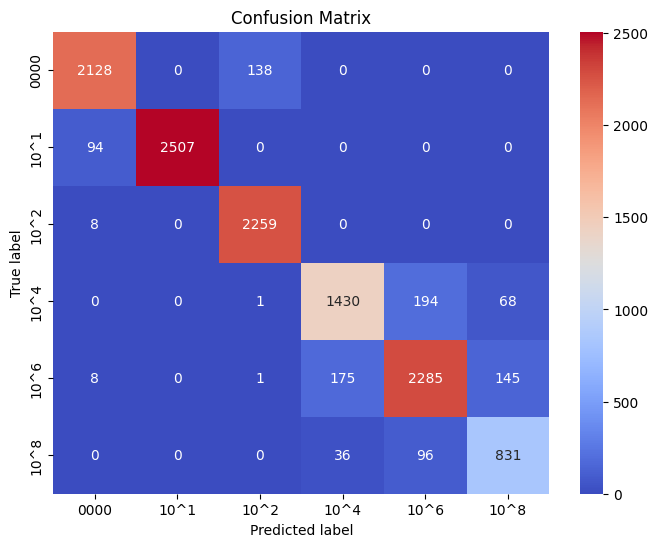

Classification Report:
              precision    recall  f1-score   support

        0000       0.95      0.94      0.94      2266
        10^1       1.00      0.96      0.98      2601
        10^2       0.94      1.00      0.97      2267
        10^4       0.87      0.84      0.86      1693
        10^6       0.89      0.87      0.88      2614
        10^8       0.80      0.86      0.83       963

    accuracy                           0.92     12404
   macro avg       0.91      0.91      0.91     12404
weighted avg       0.92      0.92      0.92     12404



In [25]:
# Apply Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Create an instance of the model
nb = GaussianNB()

# Fit the model to the training data
nb.fit(X_train, y_train)

# Predict the classes of the test data
y_pred = nb.predict(X_test)

# Print the full classification report
print_full_classification_report(y_test, y_pred, X_test=X_test, axes_names=CLASSIFICATION_PLOT_AXES, classes_names=CLASSES_SHORT)

We apply K-means

y_test = array([1, 0, 2, ..., 2, 1, 0])
y_pred = array([4, 5, 3, ..., 3, 4, 5], dtype=int32)


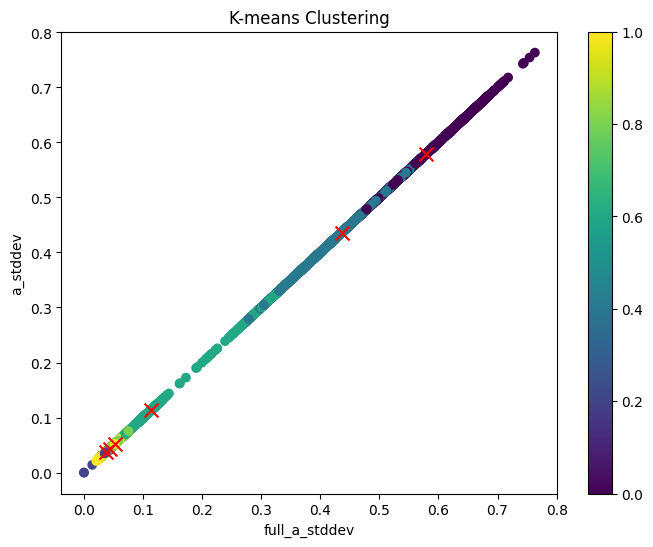

Accuracy: 0.12649145436955822
Silhouette score: 0.41154873806018766
Inertia: 2864.3283976865528
Accuracy: 0.12649145436955822
Scatter plot of the test data:


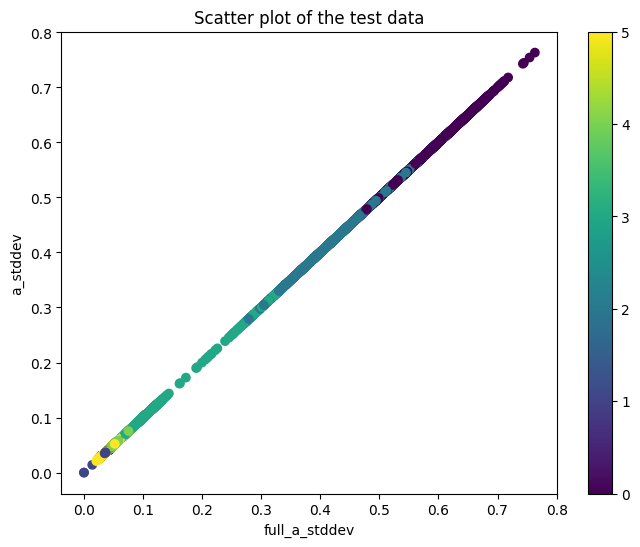

Confusion matrix:


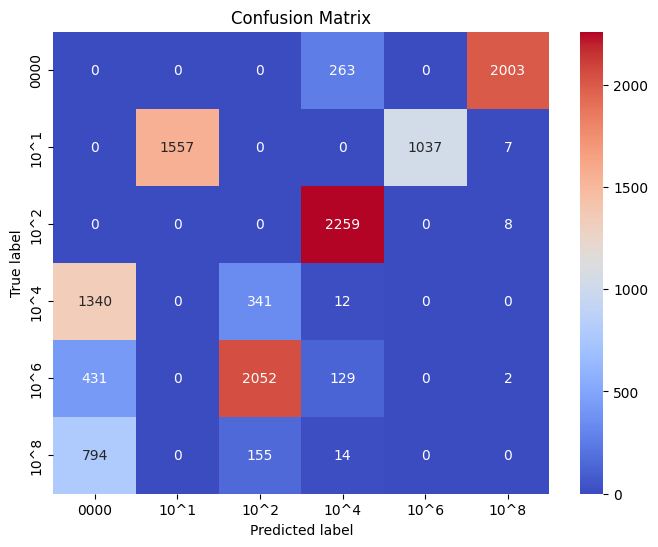

Classification Report:
              precision    recall  f1-score   support

        0000       0.00      0.00      0.00      2266
        10^1       1.00      0.60      0.75      2601
        10^2       0.00      0.00      0.00      2267
        10^4       0.00      0.01      0.01      1693
        10^6       0.00      0.00      0.00      2614
        10^8       0.00      0.00      0.00       963

    accuracy                           0.13     12404
   macro avg       0.17      0.10      0.13     12404
weighted avg       0.21      0.13      0.16     12404



In [28]:
# K-means is an unsupervised machine learning algorithm, what it does is "clustering". At the end of a clustering algorithm execution, you get clusters, that are set of points. We can associate each cluster to a class, according to some algorithm that we are currently developing, and then we get a supervised version of a clustering algorithm, because we just use the traning set features and albels (but in two separate steps).

import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, silhouette_score

np.random.seed(5)

# Set the number of clusters
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters)

# Fit the K-means model to the data
kmeans.fit(X_train)
y_pred = kmeans.predict(X_test)

print(f"{y_test = }")
print(f"{y_pred = }")

# Get the cluster centers
centroids = kmeans.cluster_centers_

# Plot the data and the cluster centers
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100)
plt.xlabel(CLASSIFICATION_PLOT_AXES[0])
plt.ylabel(CLASSIFICATION_PLOT_AXES[1])
plt.title('K-means Clustering')
plt.colorbar()
plt.show()

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate the silhouette score
silhouette = silhouette_score(X_test, y_pred)
print(f"Silhouette score: {silhouette}")

# Calculate the intertia
inertia = kmeans.inertia_
print(f"Inertia: {inertia}")

# Print the full classification report
print_full_classification_report(y_test, y_pred, X_test=X_test, axes_names=CLASSIFICATION_PLOT_AXES, classes_names=CLASSES_SHORT)

We apply K-medoids

In [ ]:
# import numpy as np
# from sklearn_extra.cluster import KMedoids
# from sklearn.metrics import accuracy_score

# np.random.seed(5)

# # Set the number of clusters
# n_clusters = 6
# kmedoids = KMedoids(n_clusters=n_clusters)

# # Fit the K-means model to the data
# kmedoids.fit(X_train)
# y_pred = kmedoids.predict(X_test)

# # Get the cluster centers
# medoids = kmedoids.cluster_centers_

# # Plot the data and the cluster centers
# plt.figure(figsize=(8, 6))
# plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis')
# plt.scatter(medoids[:, 0], medoids[:, 1], c='red', marker='x', s=100)
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
# plt.title('K-means Clustering')
# plt.colorbar()
# plt.show()

# # Calculate the accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")

# # Calculate the silhouette score
# silhouette = silhouette_score(X_test, y_pred)
# print(f"Silhouette score: {silhouette}")

# # Calculate the intertia
# inertia = kmedoids.inertia_
# print(f"Inertia: {inertia}")

We apply SVM

Accuracy: 0.9879071267333118
Scatter plot of the test data:


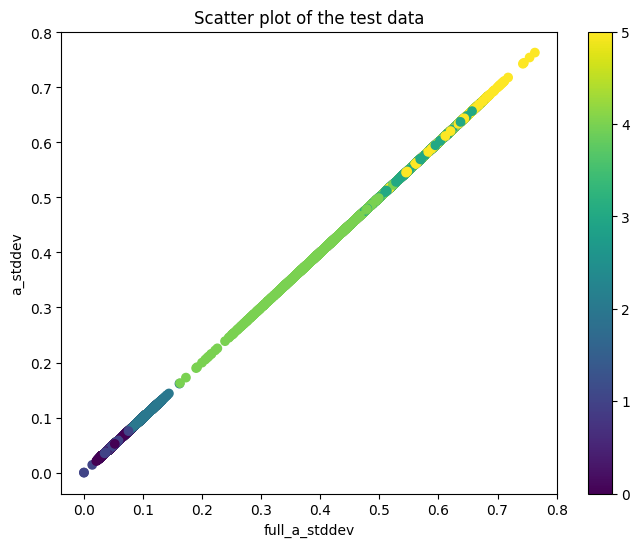

Confusion matrix:


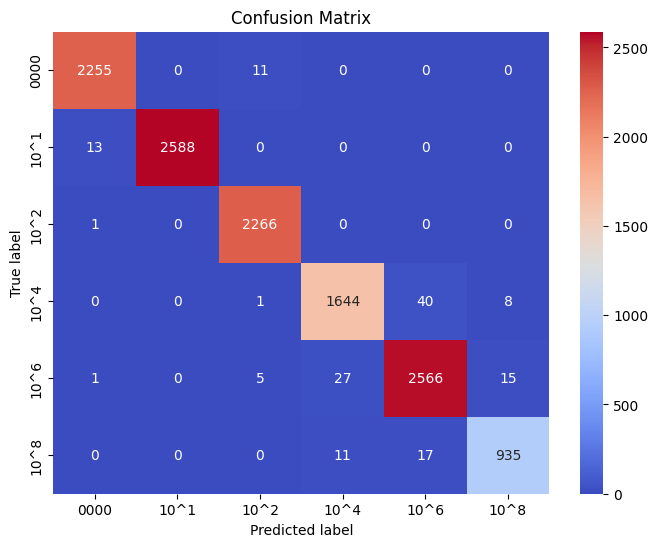

Classification Report:
              precision    recall  f1-score   support

        0000       0.99      1.00      0.99      2266
        10^1       1.00      1.00      1.00      2601
        10^2       0.99      1.00      1.00      2267
        10^4       0.98      0.97      0.97      1693
        10^6       0.98      0.98      0.98      2614
        10^8       0.98      0.97      0.97       963

    accuracy                           0.99     12404
   macro avg       0.99      0.99      0.99     12404
weighted avg       0.99      0.99      0.99     12404



In [29]:
# Apply SVM
from sklearn.svm import SVC

# Set the SVM model
svm = SVC()

# Fit the SVM model to the data
svm.fit(X_train, y_train)

# Predict the labels
y_pred = svm.predict(X_test)

# Print full classification report
print_full_classification_report(y_test, y_pred, X_test=X_test, axes_names=CLASSIFICATION_PLOT_AXES, classes_names=CLASSES_SHORT)

We apply random forest

Accuracy: 0.9925024185746534
Scatter plot of the test data:


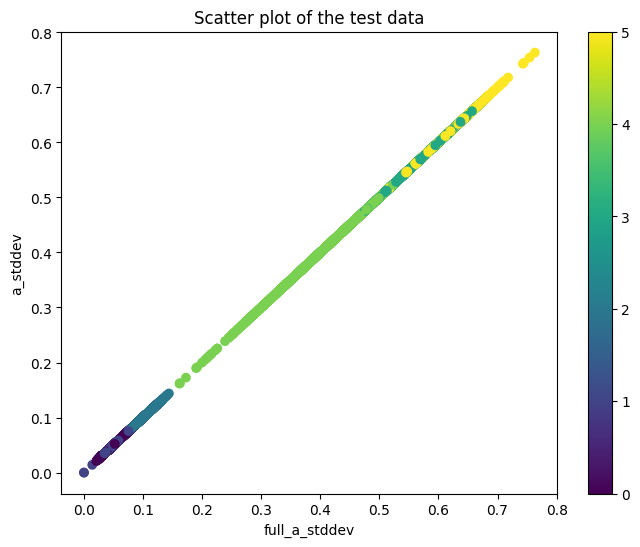

Confusion matrix:


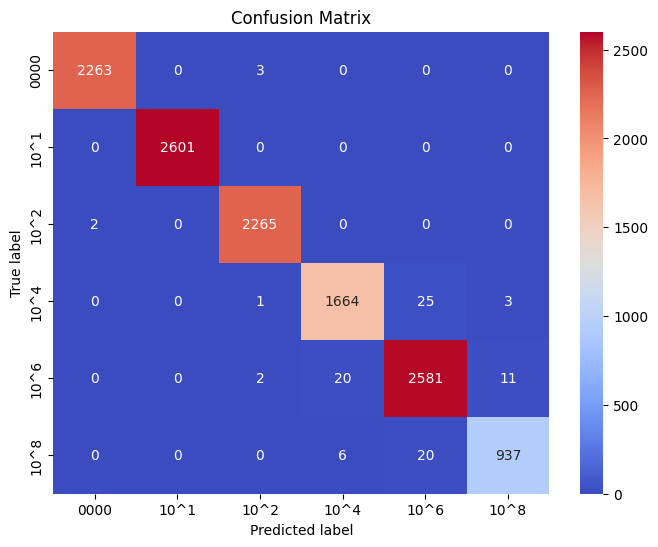

Classification Report:
              precision    recall  f1-score   support

        0000       1.00      1.00      1.00      2266
        10^1       1.00      1.00      1.00      2601
        10^2       1.00      1.00      1.00      2267
        10^4       0.98      0.98      0.98      1693
        10^6       0.98      0.99      0.99      2614
        10^8       0.99      0.97      0.98       963

    accuracy                           0.99     12404
   macro avg       0.99      0.99      0.99     12404
weighted avg       0.99      0.99      0.99     12404



In [30]:
# Train a classifier
from sklearn.ensemble import RandomForestClassifier

# Set the number of estimators
n_estimators = 10

# Create an instance of the classifier
clf = RandomForestClassifier(n_estimators=n_estimators)

# Train the classifier
clf.fit(X_train, y_train)

# Predict the labels
y_pred = clf.predict(X_test)

# Print full classification report
print_full_classification_report(y_test, y_pred, X_test=X_test, axes_names=CLASSIFICATION_PLOT_AXES, classes_names=CLASSES_SHORT)

We apply XGBoost

Accuracy: 0.9900032247662045
Scatter plot of the test data:


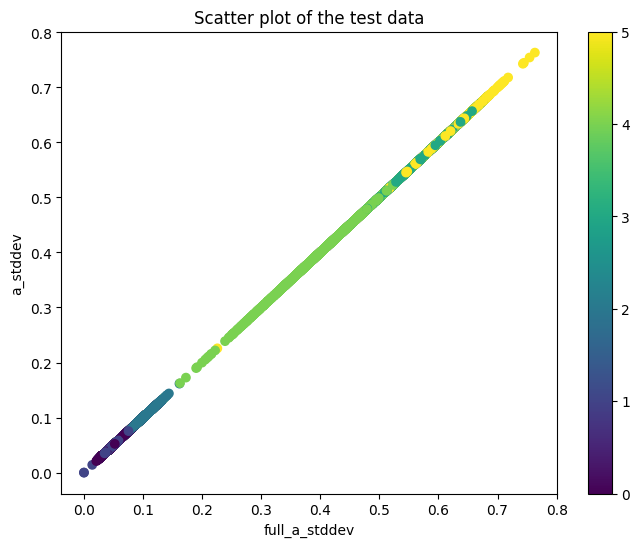

Confusion matrix:


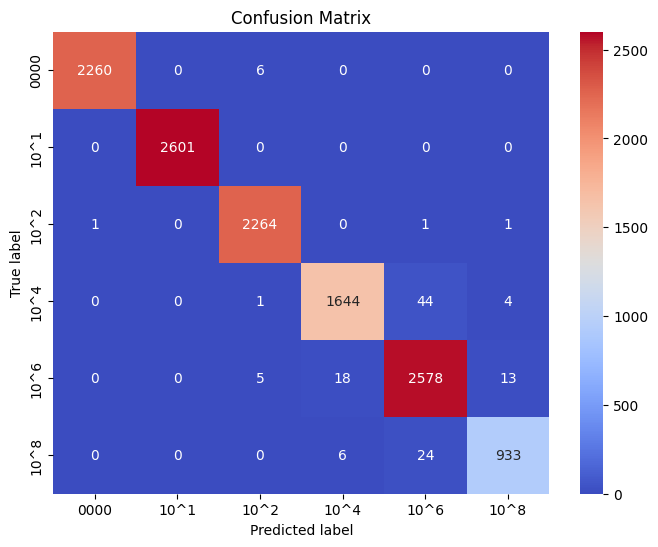

Classification Report:
              precision    recall  f1-score   support

        0000       1.00      1.00      1.00      2266
        10^1       1.00      1.00      1.00      2601
        10^2       0.99      1.00      1.00      2267
        10^4       0.99      0.97      0.98      1693
        10^6       0.97      0.99      0.98      2614
        10^8       0.98      0.97      0.97       963

    accuracy                           0.99     12404
   macro avg       0.99      0.99      0.99     12404
weighted avg       0.99      0.99      0.99     12404



In [31]:
# Apply XGBoost
import xgboost as xgb
from sklearn.metrics import silhouette_score

# Set the number of estimators
n_estimators = 10

# Create an instance of the classifier
clf = xgb.XGBClassifier(n_estimators=n_estimators)

# Train the classifier
clf.fit(X_train, y_train)

# Predict the labels
y_pred = clf.predict(X_test)

# Print full classification report
print_full_classification_report(y_test, y_pred, X_test=X_test, axes_names=CLASSIFICATION_PLOT_AXES, classes_names=CLASSES_SHORT)

We apply hierarchical clustering

In [ ]:
# # Apply hierarchical clustering
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.metrics import accuracy_score, silhouette_score

# n_clusters = 6

# classifier = AgglomerativeClustering(n_clusters=n_clusters)
# classifier.fit(X_train)
# y_pred = classifier.predict(X_test)

# # Calculate the accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")

# # Calculate the silhouette score
# silhouette = silhouette_score(X_test, y_pred)
# print(f"Silhouette score: {silhouette}")

# # Plot the data with predicted clusters
# plt.figure(figsize=(8, 6))
# plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis')
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
# plt.title('Agglomerative Clustering')
# plt.colorbar()
# plt.show()

We apply KNN

Accuracy: 0.9933892292808771
Scatter plot of the test data:


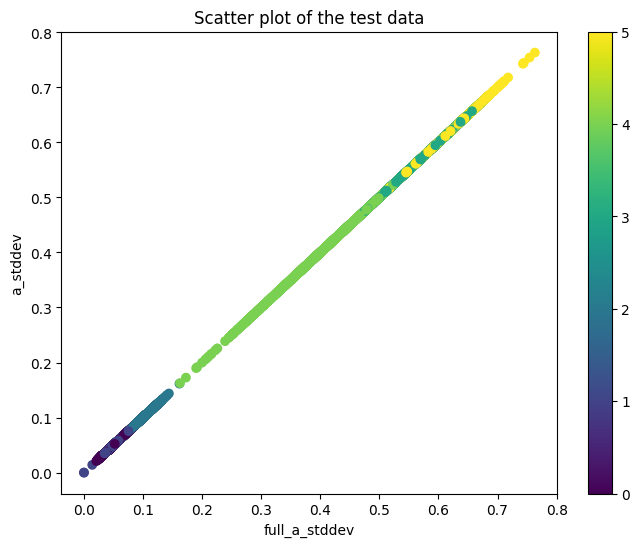

Confusion matrix:


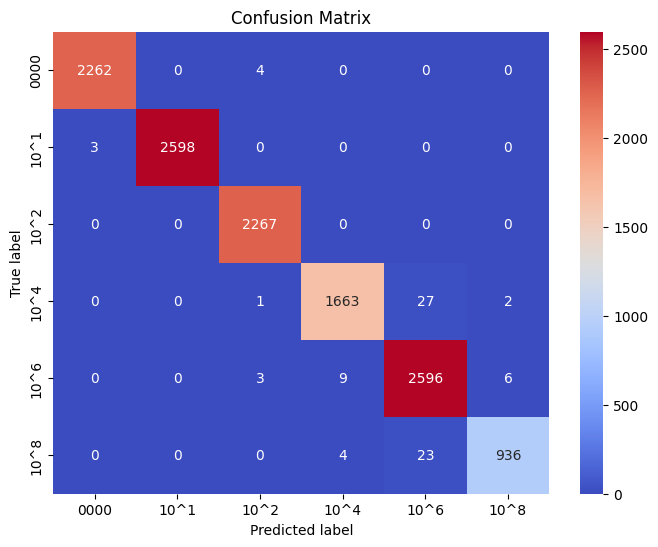

Classification Report:
              precision    recall  f1-score   support

        0000       1.00      1.00      1.00      2266
        10^1       1.00      1.00      1.00      2601
        10^2       1.00      1.00      1.00      2267
        10^4       0.99      0.98      0.99      1693
        10^6       0.98      0.99      0.99      2614
        10^8       0.99      0.97      0.98       963

    accuracy                           0.99     12404
   macro avg       0.99      0.99      0.99     12404
weighted avg       0.99      0.99      0.99     12404



In [32]:
# Apply KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Set the number of neighbors
n_neighbors = 7

# Create an instance of the classifier
clf = KNeighborsClassifier(n_neighbors=n_neighbors)

# Train the classifier
clf.fit(X_train, y_train)

# Predict the labels
y_pred = clf.predict(X_test)

# Print the full classification report
print_full_classification_report(y_test, y_pred, X_test=X_test, axes_names=CLASSIFICATION_PLOT_AXES, classes_names=CLASSES_SHORT)

### Deep learning

In [ ]:
%pip install tensorflow
%pip install pydot graphviz

In [33]:
from numpy.typing import NDArray
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle

# Import the data from pickle files
df_feature_importance_sorted = pickle.load(open('df_feature_importance_sorted.pkl', 'rb'))
X = pickle.load(open('X_feature_importance_classification.pkl', 'rb'))

# Set train, test and validation data
X: NDArray[np.float64] = X
y = pd.get_dummies(df_feature_importance_sorted["class_target"])
y = y.to_numpy(dtype=np.int32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=42, test_size=0.2)

print(f"X_train shape: {X_train.shape}")
print(f"X train example: {X_train[0]}\n")

print(f"X_valid shape: {X_valid.shape}")
print(f"X valid example: {X_valid[0]}\n")

print(f"X_test shape: {X_test.shape}")
print(f"X test example: {X_test[0]}\n")

print(f"y_train shape: {y_train.shape}")
print(f"y_train example: {y_train[0]}\n")

print(f"y_valid shape: {y_valid.shape}")
print(f"y_valid example: {y_valid[0]}\n")

print(f"y_test shape: {y_test.shape}")
print(f"y_test example: {y_test[0]}\n")

X_train shape: (39689, 15)
X train example: [0.46689957 0.46689957 0.14051095 0.77304272 0.60151713 0.75225408
 0.77304272 0.6081432  0.60151713 0.7522818  0.56573687 0.06214849
 0.60151713 0.67406017 0.77304272]

X_valid shape: (9923, 15)
X valid example: [0.05231008 0.05231008 0.47627737 0.52492282 0.09819351 0.42772261
 0.52492282 0.26213118 0.09819351 0.51575204 0.09164135 0.12514905
 0.09819351 0.34487845 0.52492282]

X_test shape: (12404, 15)
X test example: [0.04319353 0.04319353 0.01824818 0.40598983 0.10281676 0.36992976
 0.40598983 0.25713177 0.10281676 0.47902331 0.09581046 0.1724398
 0.10281676 0.21051685 0.40598983]

y_train shape: (39689, 6)
y_train example: [0 0 0 0 1 0]

y_valid shape: (9923, 6)
y_valid example: [1 0 0 0 0 0]

y_test shape: (12404, 6)
y_test example: [0 1 0 0 0 0]



In [34]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

reg = tf.keras.regularizers.l2(0.0001)

model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(5, activation='relu', input_shape=(X_train.shape[-1],), kernel_regularizer=reg),
        tf.keras.layers.Dense(5, activation='relu', kernel_regularizer=reg),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ]
)

optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.CategoricalCrossentropy()
model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy', 'mae', 'mse'])

model.summary()


# Plot the model architecture (you need to have Graphviz installed on your machine)
# plot_model(model, show_shapes=True, show_layer_names=True)

2024-08-09 14:55:39.615306: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-08-09 14:55:41.929289: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 5)              │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146 (584.00 B)

 Trainable params: 146 (584.00 B)

 Non-trainable params: 0 (0.00 B)

In [36]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=2048, verbose=1)

# Save the model and history to a file
model.save('model_feature_importance.keras')
pickle.dump(history, open('history_feature_importance.pkl', 'wb'))

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9757 - loss: 0.1110 - mae: 0.0198 - mse: 0.0069 - val_accuracy: 0.9746 - val_loss: 0.1169 - val_mae: 0.0203 - val_mse: 0.0073
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9783 - loss: 0.1047 - mae: 0.0192 - mse: 0.0065 - val_accuracy: 0.9746 - val_loss: 0.1165 - val_mae: 0.0203 - val_mse: 0.0073
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9775 - loss: 0.1105 - mae: 0.0196 - mse: 0.0068 - val_accuracy: 0.9739 - val_loss: 0.1161 - val_mae: 0.0203 - val_mse: 0.0073
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9772 - loss: 0.1104 - mae: 0.0197 - mse: 0.0069 - val_accuracy: 0.9748 - val_loss: 0.1157 - val_mae: 0.0201 - val_mse: 0.0072
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9770 - loss: 0.1066 - mae: 0.0193 - mse: 0.0067 - val_accuracy: 0.9748 - val_loss: 0.1152 - val_mae: 0.0200 - val_mse: 0.0072
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms

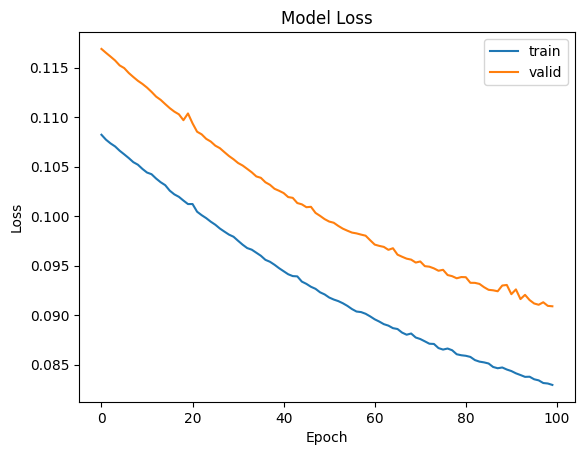

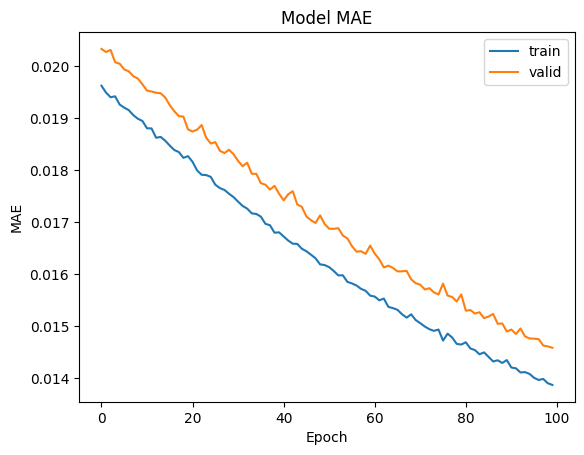

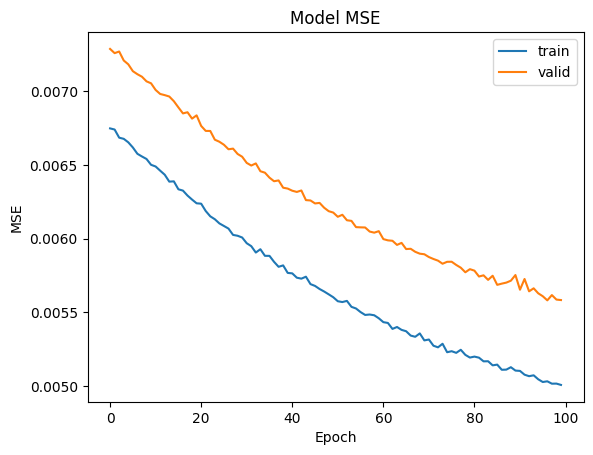

In [37]:
# Import the model and history from a file
import pickle
import tensorflow as tf

model = tf.keras.models.load_model('model_feature_importance.keras')
history = pickle.load(open('history_feature_importance.pkl', 'rb'))

create_training_history_plot(history)

388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 884us/step - accuracy: 0.9809 - loss: 0.0824 - mae: 0.0143 - mse: 0.0053
Loss: 0.08308814465999603
Accuracy: 0.9816994667053223
Mean Absolute Error: 0.013867159374058247
Mean Squared Error: 0.005166583228856325
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
First 10 predictions: [1 0 2 4 4 5 2 1 5 1]
Accuracy: 0.9816994517897453
Scatter plot of the test data:


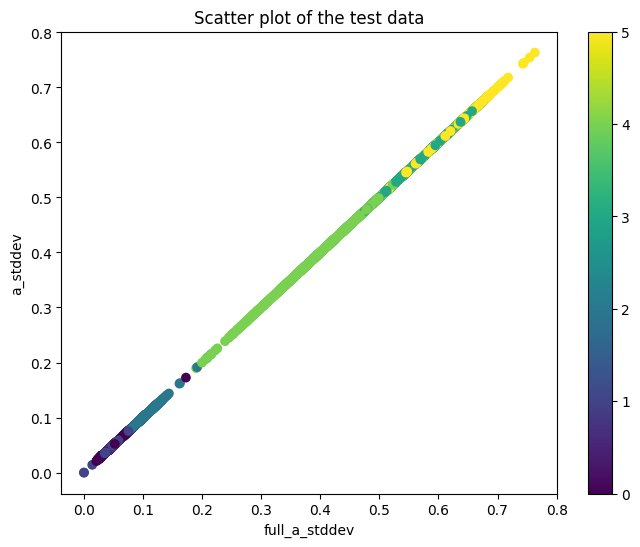

Confusion matrix:


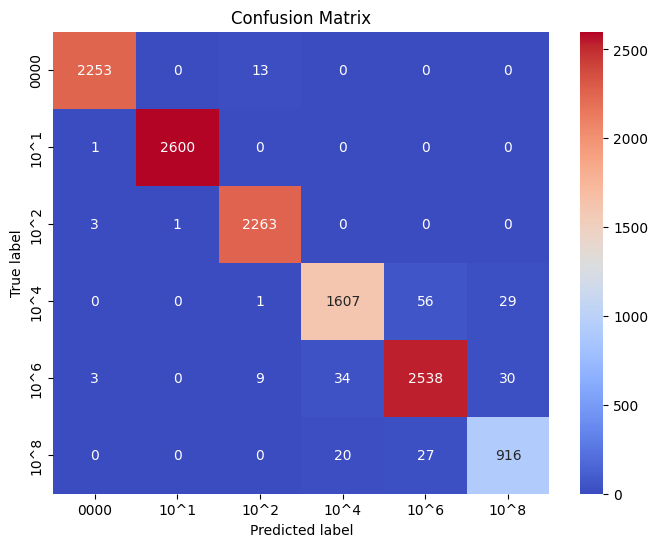

Classification Report:
              precision    recall  f1-score   support

        0000       1.00      0.99      1.00      2266
        10^1       1.00      1.00      1.00      2601
        10^2       0.99      1.00      0.99      2267
        10^4       0.97      0.95      0.96      1693
        10^6       0.97      0.97      0.97      2614
        10^8       0.94      0.95      0.95       963

    accuracy                           0.98     12404
   macro avg       0.98      0.98      0.98     12404
weighted avg       0.98      0.98      0.98     12404



In [38]:
# Evaluate the model
loss, accuracy, mae, mse = model.evaluate(X_test, y_test)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

# Predict the test data
y_pred = model.predict(X_test)

# Print accuracy
y_pred_1d = np.argmax(y_pred, axis=1)
y_test_1d = np.argmax(y_test, axis=1)

print(f"First 10 predictions: {y_pred_1d[:10]}")

# Print full classification report
print_full_classification_report(y_test_1d, y_pred_1d, X_test, axes_names=CLASSIFICATION_PLOT_AXES, classes_names=CLASSES_SHORT)

## Regression

In [41]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Set the dataset
df_feature_importance_sorted = pickle.load(open('df_feature_importance_sorted.pkl', 'rb'))

# We perform min max scaling because scaling is required for many models to perform well, other models won't be affected negatively
scaler = MinMaxScaler()
FEATURES_COLUMNS = get_features(df_feature_importance_sorted)

X = scaler.fit_transform(df_feature_importance_sorted[FEATURES_COLUMNS])
y = df_feature_importance_sorted["value_target"].to_numpy()

# Set the test size
test_size = 0.2

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X train example: {X_train[0]}\n")

print(f"X_test shape: {X_test.shape}")
print(f"X test example: {X_test[0]}\n")

print(f"y_train shape: {y_train.shape}")
print(f"y_train example: {y_train[0]}\n")

print(f"y_test shape: {y_test.shape}")
print(f"y_test example: {y_test[0]}\n")

# Save to pickle files
pickle.dump(X, open('X_feature_importance_regression.pkl', 'wb'))
pickle.dump(X_train, open('X_feature_importance_train_regression.pkl', 'wb'))
pickle.dump(X_test, open('X_feature_importance_test_regression.pkl', 'wb'))
pickle.dump(y, open('y_feature_importance_regression.pkl', 'wb'))
pickle.dump(y_train, open('y_feature_importance_train_regression.pkl', 'wb'))
pickle.dump(y_test, open('y_feature_importance_test_regression.pkl', 'wb'))

X_train shape: (49612, 15)
X train example: [0.03002198 0.03002198 0.51459854 0.48554863 0.05826815 0.25713777
 0.48554863 0.24053471 0.05826815 0.46582945 0.0627535  0.13494003
 0.05826815 0.30688604 0.48554863]

X_test shape: (12404, 15)
X test example: [0.04319353 0.04319353 0.01824818 0.40598983 0.10281676 0.36992976
 0.40598983 0.25713177 0.10281676 0.47902331 0.09581046 0.1724398
 0.10281676 0.21051685 0.40598983]

y_train shape: (49612,)
y_train example: 0.217

y_test shape: (12404,)
y_test example: 0.275



We use the mean of the target value as baseline model

In [42]:
import numpy as np

# Calculate the mean of the target variable in the training set
mean_train = np.mean(y_train)

# Predict the mean for all instances in the test set
y_pred = np.full_like(y_test, mean_train)

print_full_regression_report(y_test, y_pred)

Mean absolute error: 0.1535707778169625
Mean squared error: 0.05220064767296237
Mean relative error: 0.4167235512808918


We use Linear Regression

In [43]:
# Do regression using Linear Regression
from sklearn.linear_model import LinearRegression

# Set the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predict the values
y_pred = model.predict(X_test)

# Print full regression report
print_full_regression_report(y_test, y_pred)

Mean absolute error: 0.07223295022035121
Mean squared error: 0.010731138897577054
Mean relative error: 0.18447798996735126


We use Random Forest Regressor

In [44]:
# Do regression using Random Forest
from sklearn.ensemble import RandomForestRegressor

# Set the model
model = RandomForestRegressor(n_estimators=50)

# Train the model
model.fit(X_train, y_train)

# Predict the values
y_pred = model.predict(X_test)

# Print full regression report
print_full_regression_report(y_test, y_pred)

Mean absolute error: 0.015212399642984046
Mean squared error: 0.0019440170867633406
Mean relative error: 0.02896811111046854


We use XGBoost

In [45]:
# Do regression using XGBoost
import xgboost as xgb

# Set the model
model = xgb.XGBRegressor(n_estimators=50)

# Train the model
model.fit(X_train, y_train)

# Predict the values
y_pred = model.predict(X_test)

# Print full regression report
print_full_regression_report(y_test, y_pred)

Mean absolute error: 0.018177936072706683
Mean squared error: 0.0020841278382878383
Mean relative error: 0.036247384430583715


We use KNN Regressor

In [46]:
# Do regression using KNN
from sklearn.neighbors import KNeighborsRegressor

# Set the model
model = KNeighborsRegressor(n_neighbors=7)

# Train the model
model.fit(X_train, y_train)

# Predict the values
y_pred = model.predict(X_test)

# Print full regression report
print_full_regression_report(y_test, y_pred)

Mean absolute error: 0.016961003362970472
Mean squared error: 0.0024522829831061742
Mean relative error: 0.03078806293443418


We use SVR (Support Vector Regressor)

In [47]:
# Do regression using SVR
from sklearn.svm import SVR

# Set the model
model = SVR()

# Train the model
model.fit(X_train, y_train)

# Predict the values
y_pred = model.predict(X_test)

# Print full regression report
print_full_regression_report(y_test, y_pred)

Mean absolute error: 0.05522859395478791
Mean squared error: 0.005739890051993678
Mean relative error: 0.16201844644015156


### Deep learning

We create one neural network and we train 3 different models: one with no scaling, one with MinMaxScaler and one with StandardScaler

In [48]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

# Identity Scaler
from sklearn.base import BaseEstimator, TransformerMixin

class IdentityScaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X
    
    # def fit_transform(self, X):
    #     return X


# Set the dataset
df_feature_importance_sorted = pickle.load(open('df_feature_importance_sorted.pkl', 'rb'))
FEATURES_COLUMNS = get_features(df_feature_importance_sorted)
scalers = [IdentityScaler(), MinMaxScaler(), StandardScaler()]
scaler_names = ["No scaling", "Min-Max Scaler", "Standard Scaler"]

test_size = 0.2

X_raw = df_feature_importance_sorted[FEATURES_COLUMNS].to_numpy()
y_raw = df_feature_importance_sorted["value_target"].to_numpy()

Xs = []
ys = []

scaled_datasets = []

for i in range(len(scalers)):
    scaler = scalers[i]
    
    X = scaler.fit_transform(X_raw)
    # y = scaler.fit_transform(y_raw.reshape(-1, 1))
    y = y_raw.reshape(-1, 1)
    
#     print(f"Testing {scaler_names[i]} (ACTUALLY just NO SCALER WILL PASS)")
    
#     assert len(y_raw.reshape(-1, 1)) == len(y)
    
#     for j in range(len(y)):
#         assert y_raw.reshape(-1, 1)[j] == y[j], f"Error with {j}"
    
    Xs.append(X)
    ys.append(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=42, test_size=0.2)

    scaled_datasets.append([X_train, X_valid, X_test, y_train, y_valid, y_test])
    
    print(f"Data scaled with: {scaler_names[i]}")
    print(f"\tX_train shape: {X_train.shape}")
    print(f"\tX train example: {X_train[0]}\n")

    print(f"\tX_valid shape: {X_valid.shape}")
    print(f"\tX valid example: {X_valid[0]}\n")

    print(f"\tX_test shape: {X_test.shape}")
    print(f"\tX test example: {X_test[0]}\n")

    print(f"\ty_train shape: {y_train.shape}")
    print(f"\ty_train example: {y_train[0]}\n")

    print(f"\ty_valid shape: {y_valid.shape}")
    print(f"\ty_valid example: {y_valid[0]}\n")

    print(f"\ty_test shape: {y_test.shape}")
    print(f"\ty_test example: {y_test[0]}\n")

    # # Save to pickle files
    # pickle.dump(X, open('X_numeric_regression_deep.pkl', 'wb'))
    # pickle.dump(X_train, open('X_numeric_train_regression_deep.pkl', 'wb'))
    # pickle.dump(X_valid, open('X_numeric_valid_regression_deep.pkl', 'wb'))
    # pickle.dump(X_test, open('X_numeric_test_regression_deep.pkl', 'wb'))
    # pickle.dump(y, open('y_numeric_regression_deep.pkl', 'wb'))
    # pickle.dump(y_train, open('y_numeric_train_regression_deep.pkl', 'wb'))
    # pickle.dump(y_valid, open('y_numeric_valid_regression_deep.pkl', 'wb'))
    # pickle.dump(y_test, open('y_numeric_test_regression_deep.pkl', 'wb'))

Data scaled with: No scaling
	X_train shape: (39689, 15)
	X train example: [  8.69303672   8.69303672 177.         130.51798425 143.11193701
   3.4648498  130.51798425  52.61305833 143.11193701  67.02509428
 145.41158873   1.68363341 143.11193701 130.5334593  130.51798425]

	X_valid shape: (9923, 15)
	X valid example: [  0.97394269   0.97394269 361.         122.65423016 129.06121913
   1.97007187 122.65423016  22.67808522 129.06121913  45.95130294
 129.           3.39035008 129.06121913 121.4592775  122.65423016]

	X_test shape: (12404, 15)
	X test example: [  0.80420493   0.80420493 110.         118.88484371 129.19028106
   1.70388051 118.88484371  22.24556509 129.19028106  42.67893006
 129.14432042   4.67148    129.19028106 117.7554826  118.88484371]

	y_train shape: (39689, 1)
	y_train example: [0.579]

	y_valid shape: (9923, 1)
	y_valid example: [0.202]

	y_test shape: (12404, 1)
	y_test example: [0.275]

Data scaled with: Min-Max Scaler
	X_train shape: (39689, 15)
	X train example

In [ ]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# # Scale X
# scaler.fit(X)

# X_train_scaled = scaler.transform(X_train)
# X_valid_scaled = scaler.transform(X_valid)
# X_test_scaled = scaler.transform(X_test)

# # Scale y
# scaler.fit(y.reshape(-1, 1))

# y_train_scaled = scaler.transform(y_train.reshape(-1, 1))
# y_valid_scaled = scaler.transform(y_valid.reshape(-1, 1))
# y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

In [49]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

reg = tf.keras.regularizers.l2(0.0001)
models = []

for i in range(len(scalers)):
    models.append(tf.keras.models.Sequential(
            [
                tf.keras.layers.Dense(5, activation='relu', input_shape=(Xs[i].shape[-1],), kernel_regularizer=reg),
                tf.keras.layers.Dense(5, activation='relu', kernel_regularizer=reg),
                tf.keras.layers.Dense(1, activation='linear')
            ]
        )
    )

for model in models:
    optimizer = tf.keras.optimizers.Adam()
    optimizer_scaled = tf.keras.optimizers.Adam()
    loss_function = tf.keras.losses.MeanSquaredError()
    loss_function_scaled = tf.keras.losses.MeanSquaredError()

    model.compile(loss=loss_function, optimizer=optimizer, metrics=['mae', 'mse'])
    model.summary()
    
    # I don't know why this plot is not printing
    # plot_model(model, show_shapes=True, show_layer_names=True)
    

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 5)              │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116 (464.00 B)

 Trainable params: 116 (464.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 5)              │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116 (464.00 B)

 Trainable params: 116 (464.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 5)              │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116 (464.00 B)

 Trainable params: 116 (464.00 B)

 Non-trainable params: 0 (0.00 B)

In [50]:
histories = []

for i in range(len(models)):
    print(f"\nTraining neural network with data scaled with {scaler_names[i]}")
    X_train, X_valid, X_test, y_train, y_valid, y_test = scaled_datasets[i]
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=2048, verbose=1)
    histories.append(history)


Training neural network with data scaled with No scaling
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 15525.7656 - mae: 123.0013 - mse: 15525.7627 - val_loss: 5792.1772 - val_mae: 74.9315 - val_mse: 5792.1763
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3987.4324 - mae: 60.1202 - mse: 3987.4309 - val_loss: 755.6382 - val_mae: 22.0620 - val_mse: 755.6369
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 527.1674 - mae: 16.8231 - mse: 527.1660 - val_loss: 292.6729 - val_mae: 13.5201 - val_mse: 292.6715
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 288.8302 - mae: 13.5480 - mse: 288.8289 - val_loss: 273.4674 - val_mae: 13.0846 - val_mse: 273.4661
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 261.5999 - mae: 12.6134 - mse: 261.5986 - val_loss: 240.5699 - val_mae: 11.6313 - val_mse: 240.5686
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 230.8425 - mae: 11.2745 - mse: 230.8412 - val_loss: 218.1672 - val_mae: 10.852


Showing history of training of neural network with data scaled with No scaling


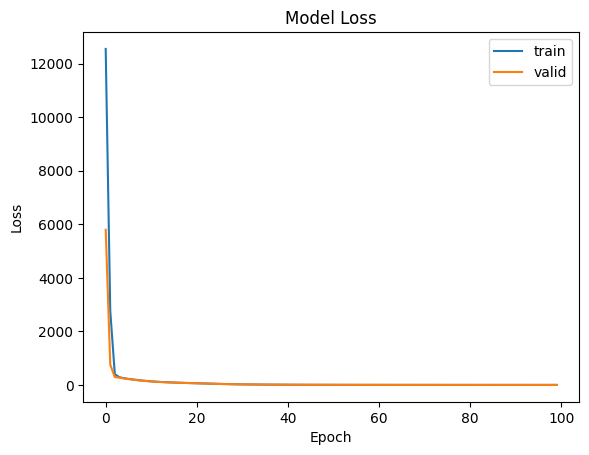

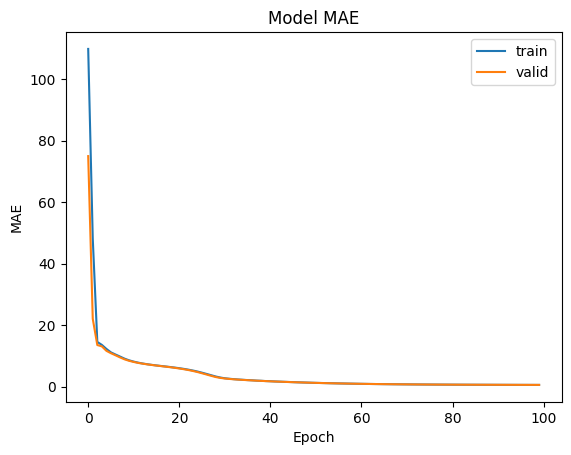

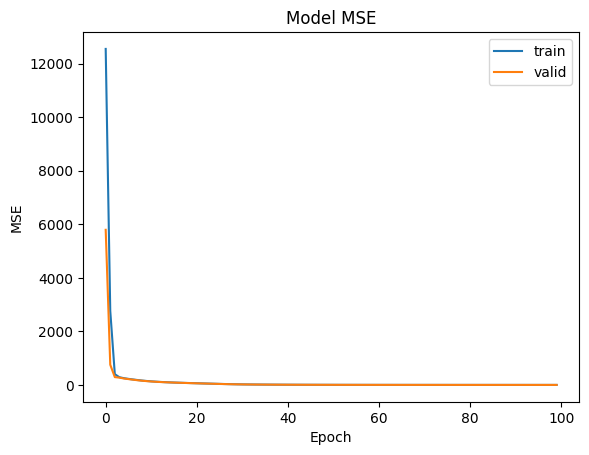


Showing history of training of neural network with data scaled with Min-Max Scaler


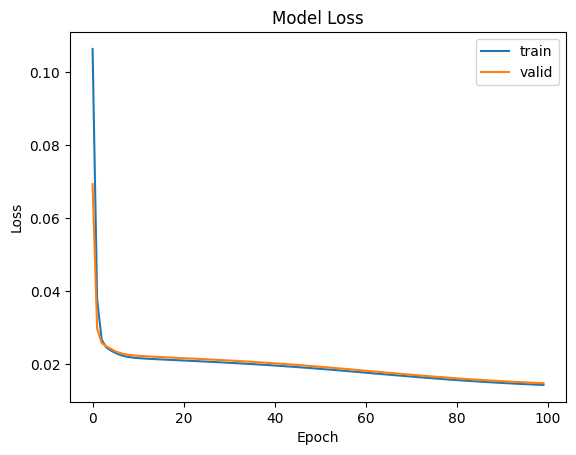

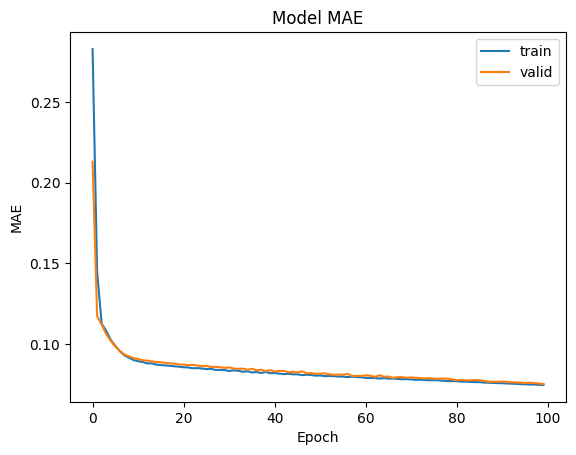

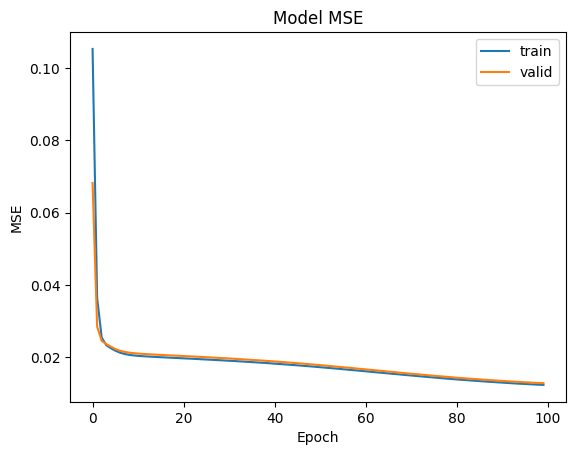


Showing history of training of neural network with data scaled with Standard Scaler


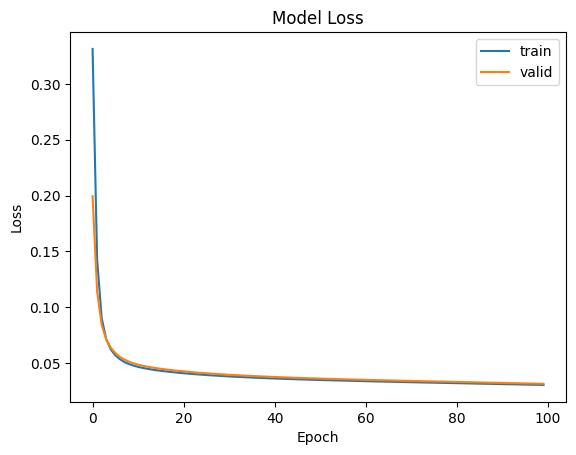

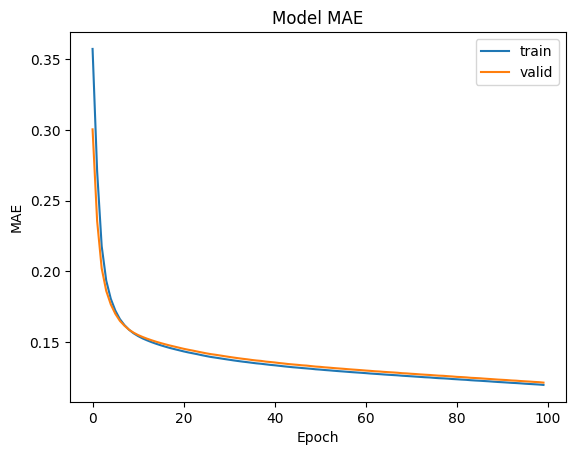

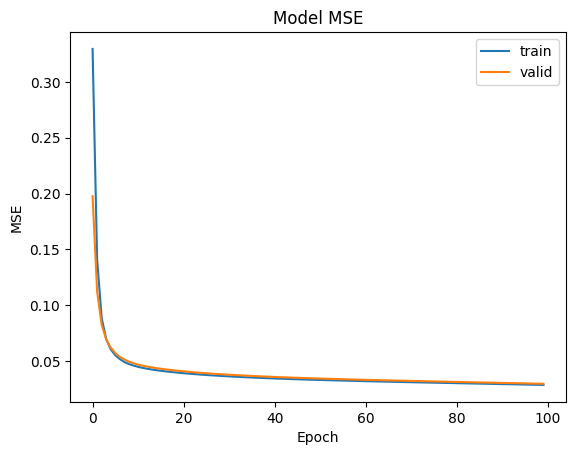

In [51]:
for i in range(len(histories)):
    print(f"\nShowing history of training of neural network with data scaled with {scaler_names[i]}")
    create_training_history_plot(histories[i])

In [52]:
for i in range(len(models)):
    model = models[i]
    X_train, X_valid, X_test, y_train, y_valid, y_test = scaled_datasets[i]
    print(f"\nEvaluating model trained with data scaled with {scaler_names[i]}")
    
    loss, mae, mse = model.evaluate(X_test, y_test)
    print(f"Loss: {loss}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")

    # Predict the test data
    y_pred = model.predict(X_test)

    # Print full regression report
    print_full_regression_report(y_test, y_pred)


Evaluating model trained with data scaled with No scaling
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - loss: 0.2117 - mae: 0.3958 - mse: 0.2105
Loss: 0.20806846022605896
Mean Absolute Error: 0.3932432234287262
Mean Squared Error: 0.20683832466602325
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
Mean absolute error: 0.39324306675266046
Mean squared error: 0.20683842558851984
Mean relative error: 1.0

Evaluating model trained with data scaled with Min-Max Scaler
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - loss: 0.1285 - mae: 0.2721 - mse: 0.1272
Loss: 0.12581807374954224
Mean Absolute Error: 0.26957887411117554
Mean Squared Error: 0.12457064539194107
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
Mean absolute error: 0.26957893762932367
Mean squared error: 0.12457064432505759
Mean relative error: 0.6136758231683165

Evaluating model trained with data scaled with Standard Scaler
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 0.0285 - mae: 0.1173 - mse: 0.0268
Loss: 0.028848964720964432
Mea

In [53]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

reg = tf.keras.regularizers.l2(0.0001)
models_v2 = []

for i in range(len(scalers)):
    models_v2.append(
        tf.keras.models.Sequential(
            [
                tf.keras.layers.Dense(128, activation='relu', input_shape=(Xs[i].shape[-1],), kernel_initializer='normal', kernel_regularizer=reg),
                tf.keras.layers.Dense(256, activation='relu', kernel_initializer='normal', kernel_regularizer=reg),
                tf.keras.layers.Dense(256, activation='relu', kernel_initializer='normal', kernel_regularizer=reg),
                tf.keras.layers.Dense(256, activation='relu', kernel_initializer='normal', kernel_regularizer=reg),
                tf.keras.layers.Dense(1, activation='linear', kernel_initializer='normal', kernel_regularizer=reg)
            ]
        )
    )

for model in models_v2:
    optimizer = tf.keras.optimizers.Adam()
    loss_function = tf.keras.losses.MeanAbsoluteError()

    
    model.compile(loss=loss_function, optimizer=optimizer, metrics=['mae', 'mse'])
    model.summary()
    
    # I don't know why this plot is not printing
    # plot_model(model, show_shapes=True, show_layer_names=True)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,913 (652.00 KB)

 Trainable params: 166,913 (652.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,913 (652.00 KB)

 Trainable params: 166,913 (652.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,913 (652.00 KB)

 Trainable params: 166,913 (652.00 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
histories_v2 = []

for i in range(len(models_v2)):
    print(f"\nTraining neural network with data scaled with {scaler_names[i]}")
    X_train, X_valid, X_test, y_train, y_valid, y_test = scaled_datasets[i]
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=2048, verbose=1)
    histories_v2.append(history)


Training neural network with data scaled with No scaling
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.6315 - mae: 1.5928 - mse: 4.2053 - val_loss: 0.2583 - val_mae: 0.2269 - val_mse: 0.0626
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1879 - mae: 0.1582 - mse: 0.0539 - val_loss: 0.1259 - val_mae: 0.1004 - val_mse: 0.0381
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1217 - mae: 0.0971 - mse: 0.0376 - val_loss: 0.1087 - val_mae: 0.0863 - val_mse: 0.0340
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1054 - mae: 0.0835 - mse: 0.0316 - val_loss: 0.0998 - val_mae: 0.0792 - val_mse: 0.0291
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0988 - mae: 0.0785 - mse: 0.0287 - val_loss: 0.0970 - val_mae: 0.0775 - val_mse: 0.0299
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0985 - mae: 0.0791 - mse: 0.0294 - val_loss: 0.0983 - val_mae: 0.0794 - val_mse: 0.0280
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 


Showing history of training of neural network with data scaled with Standard Scaler


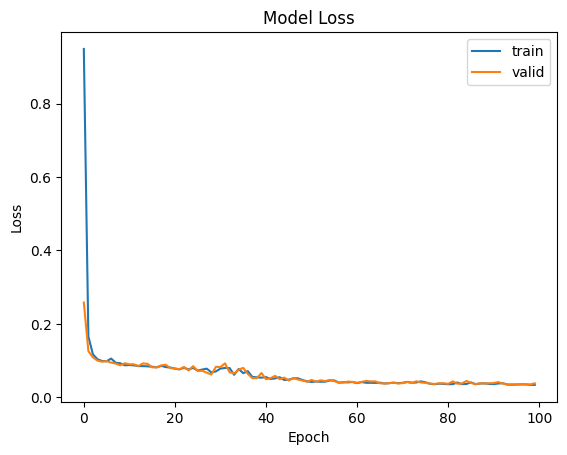

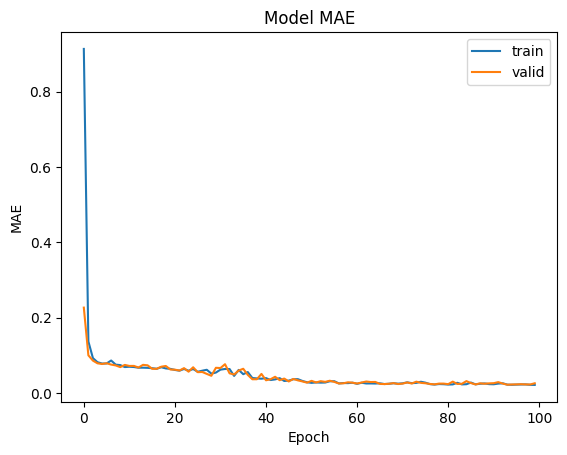

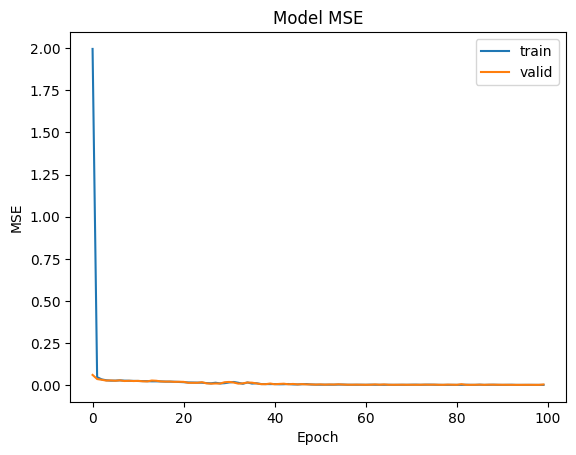


Showing history of training of neural network with data scaled with Standard Scaler


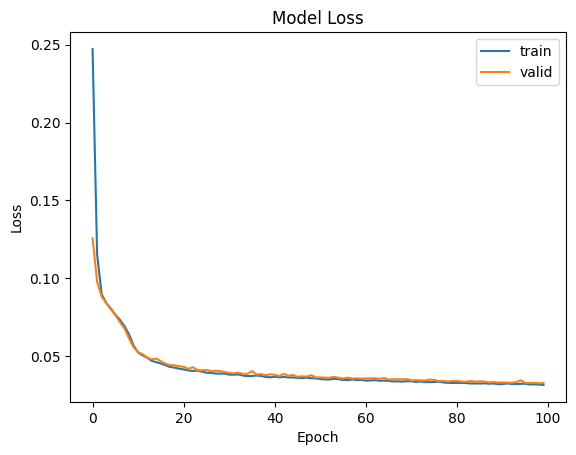

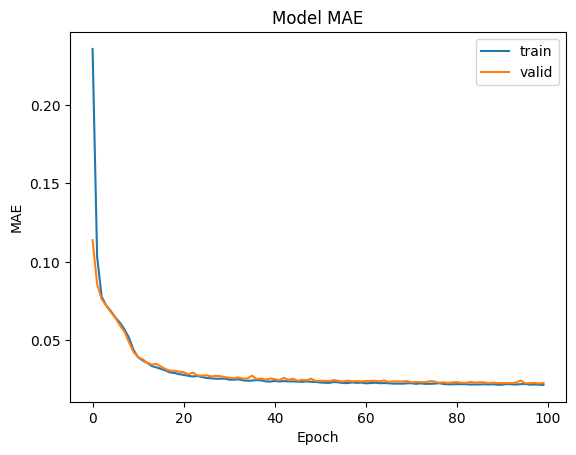

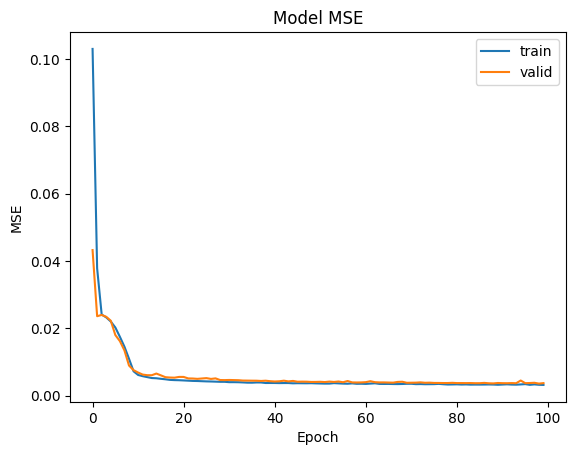


Showing history of training of neural network with data scaled with Standard Scaler


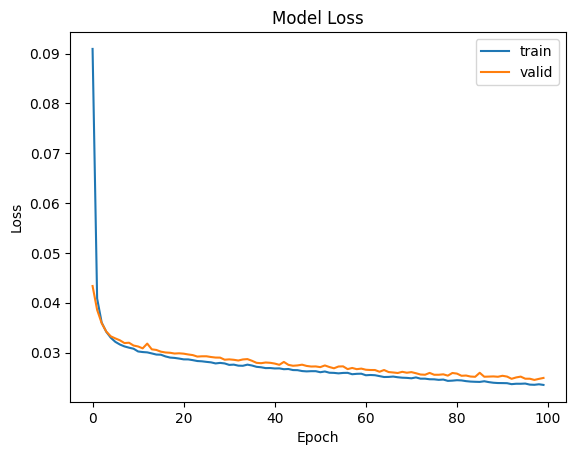

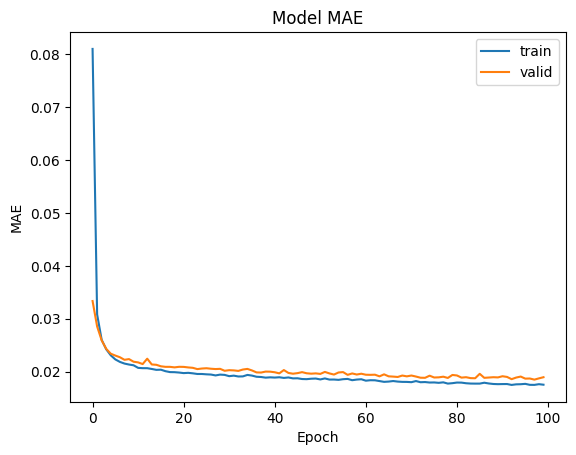

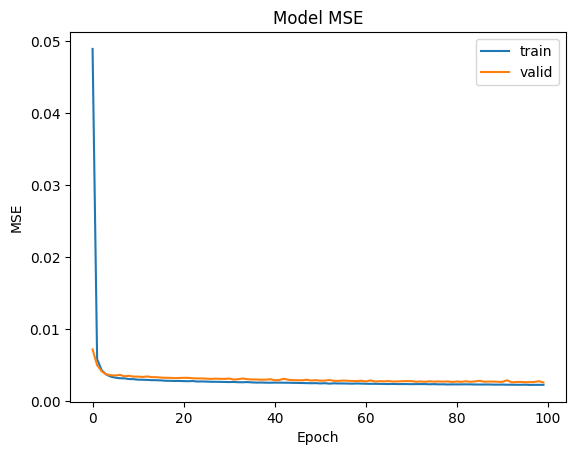

In [55]:
for history in histories_v2:
    print(f"\nShowing history of training of neural network with data scaled with {scaler_names[i]}")
    create_training_history_plot(history)

In [56]:
for i in range(len(models_v2)):
    model = models_v2[i]
    X_train, X_valid, X_test, y_train, y_valid, y_test = scaled_datasets[i]
    print(f"\nEvaluating model trained with data scaled with {scaler_names[i]}")
    
    # Evaluate the model
    loss, mae, mse = model.evaluate(X_test, y_test)
    print(f"Loss: {loss}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")

    # Predict the test data
    y_pred = model.predict(X_test)

    # Print full regression report
    print_full_regression_report(y_test, y_pred)


Evaluating model trained with data scaled with No scaling
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0687 - mae: 1.0271 - mse: 1.1368
Loss: 1.0693224668502808
Mean Absolute Error: 1.0277607440948486
Mean Squared Error: 1.1367765665054321
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean absolute error: 1.0277609748754029
Mean squared error: 1.136776087847334
Mean relative error: 2.9858879925591424

Evaluating model trained with data scaled with Min-Max Scaler
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4409 - mae: 0.3994 - mse: 0.2134
Loss: 0.4383314251899719
Mean Absolute Error: 0.3967812657356262
Mean Squared Error: 0.2097512036561966
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Mean absolute error: 0.3967812605289585
Mean squared error: 0.20975123154527014
Mean relative error: 1.0104581811820228

Evaluating model trained with data scaled with Standard Scaler
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0241 - mae: 0.0182 - mse: 0.0021
Loss: 0.024334371089935303
Mean 